In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 37.4 MB/s eta 0:00:00


In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

Dataset is https://www.kaggle.com/datasets/emirhanai/human-action-detection-artificial-intelligence


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp -av /content/drive/MyDrive/action.zip /content/action.zip

'/content/drive/MyDrive/action.zip' -> '/content/action.zip'


In [ ]:
!unzip action.zip

Streaming output truncated to the last 5000 lines.
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_099.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_100.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_101 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_101.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_102.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_103.jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (2).jpg  
  inflating: emirhan_human_dataset/datasets/human_data/train_data/running/images_104 (3).jpg  
  inflating: emirha

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

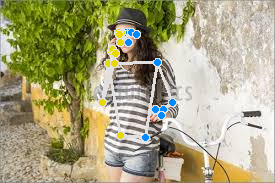

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("/content/emirhan_human_dataset/datasets/human_data/test_data/calling/images_011 (2).jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

In [ ]:
pose_list=[[i for i in data_point] for data_point in detection_result.pose_landmarks]

In [ ]:
pose_list=pose_list[0]
print(pose_list[0])

NormalizedLandmark(x=0.5322373509407043, y=0.31566083431243896, z=-0.42684200406074524, visibility=0.9999620914459229, presence=0.9999858140945435)


In [ ]:
poses=[(data.x,data.y,data.z) for data in pose_list]

In [ ]:
print(len(poses))

33


In [ ]:
final_poses=poses[10:25]

In [ ]:
print(len(final_poses))

15


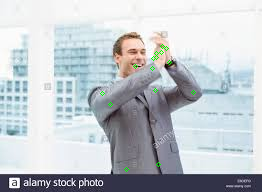

In [ ]:
img=cv2.imread("/content/emirhan_human_dataset/datasets/human_data/train_data/fighting/images_112 (4).jpg")
h,w,_ = img.shape
for i in final_poses:
  centre=(int(i[0]*w),int(i[1]*h))
  cv2.circle(img,centre,2,(0,255,0),1)
cv2_imshow(img)

##Prepare Training data

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os

In [ ]:
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

classes_to_include=['calling','sleeping','sitting']
def get_keypoints(img):
  image = mp.Image.create_from_file(img)
  detection_result = detector.detect(image)
  pose_list=[[i for i in data_point] for data_point in detection_result.pose_landmarks]
  if len(pose_list)>0:
    poses=[(data.x,data.y,data.z) for data in pose_list[0]]
    # poses=poses[10:25]
    final=[]
    first=(poses[0])
    for pose in poses:
      final.append((pose[0]-first[0],pose[1]-first[1],pose[2]-first[2]))
    return True,final
  return False,0

In [ ]:
keypoints=[]
labels=[]
dataset_path="/content/emirhan_human_dataset/datasets/human_data/train_data"
for folder in os.listdir(dataset_path):
  if folder in classes_to_include:
    print(folder)
    for i in os.listdir(os.path.join(dataset_path,folder)):
      flag,kp=get_keypoints(os.path.join(dataset_path,folder,i))
      if flag:
        keypoints.append(kp)
        labels.append(folder)

print(len(labels))
print(len(keypoints))

sleeping
calling
sitting
2733
2733


In [ ]:
print(len(keypoints[0]))

33


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [ ]:
print(label_encoder.classes_)

['calling' 'sitting' 'sleeping']


In [ ]:
print(len(encoded_labels))

2733


In [ ]:
import pickle
with open('keypoints.pkl', 'wb') as file:
    pickle.dump(keypoints, file)

with open('labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

with open('encoded_labels.pkl', 'wb') as file:
    pickle.dump(encoded_labels, file)

In [ ]:
#pkl files saved to drive

# with open('keypoints.pkl', 'rb') as file:
#   keypoints = pickle.load(file)

# with open('labels.pkl', 'rb') as file:
#   labels = pickle.load(file)

# with open('encoded_labels.pkl', 'rb') as file:
#   encoded_labels = pickle.load(file)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(keypoints, encoded_labels, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

2186
2186
547
547


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.Tensor(self.features[idx])[:,0], torch.LongTensor([self.labels[idx]])


In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

##Making the MLP

In [ ]:
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        # self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(negative_slope=0.1)
        # self.relu = nn.PReLU()
        # self.fc2 = nn.Linear(50, 100)
        # self.fc3 = nn.Linear(50,100)
        # self.fc4 = nn.Linear(100,50)
        self.fc5 = nn.Linear(50,30)
        # self.fc6 = nn.Linear(30,10)
        self.fc7 = nn.Linear(30,output_size)
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # x = self.fc2(x)
        # x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        # x = self.fc4(x)
        # x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        # x = self.fc6(x)
        # x = self.relu(x)
        x = self.fc7(x)
        x = self.sigmoid(x)

        return x

In [ ]:
model = MLP(input_size=33, output_size=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from torchsummary import summary
summary(model,input_size=(33,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]           1,700
         LeakyReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 30]           1,530
         LeakyReLU-4                   [-1, 30]               0
            Linear-5                    [-1, 5]             155
           Sigmoid-6                    [-1, 5]               0
Total params: 3,385
Trainable params: 3,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


##Training loop

In [ ]:
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.view_as(predicted)).sum().item()

    average_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.4%}')

model.eval()

Epoch 1/100, Loss: 1.1068, Val Loss: 1.1438, Accuracy: 67.0932%
Epoch 2/100, Loss: 1.0571, Val Loss: 1.1027, Accuracy: 76.7824%
Epoch 3/100, Loss: 1.0174, Val Loss: 1.0763, Accuracy: 79.8903%
Epoch 4/100, Loss: 1.0236, Val Loss: 1.0691, Accuracy: 80.6216%
Epoch 5/100, Loss: 0.9821, Val Loss: 1.0607, Accuracy: 79.7075%
Epoch 6/100, Loss: 1.0135, Val Loss: 1.0612, Accuracy: 80.6216%
Epoch 7/100, Loss: 0.9984, Val Loss: 1.0545, Accuracy: 81.1700%
Epoch 8/100, Loss: 1.0202, Val Loss: 1.0729, Accuracy: 80.4388%
Epoch 9/100, Loss: 0.9827, Val Loss: 1.0547, Accuracy: 80.8044%
Epoch 10/100, Loss: 1.0010, Val Loss: 1.0582, Accuracy: 81.9013%
Epoch 11/100, Loss: 1.0033, Val Loss: 1.0609, Accuracy: 81.3528%
Epoch 12/100, Loss: 0.9967, Val Loss: 1.0596, Accuracy: 80.9872%
Epoch 13/100, Loss: 0.9900, Val Loss: 1.0526, Accuracy: 82.2669%
Epoch 14/100, Loss: 1.0242, Val Loss: 1.0666, Accuracy: 80.9872%
Epoch 15/100, Loss: 1.0143, Val Loss: 1.0579, Accuracy: 80.4388%
Epoch 16/100, Loss: 1.0030, Val Lo

MLP(
  (fc1): Linear(in_features=33, out_features=50, bias=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (fc5): Linear(in_features=50, out_features=30, bias=True)
  (fc7): Linear(in_features=30, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# torch.save(model, 'mlp_human_action_.pth')
torch.save(model.state_dict(), 'your_model_state_dict.pth')

In [ ]:
# model = MLP(input_size=15, output_size=len(label_encoder.classes_))
# model.load_state_dict(torch.load('your_model_state_dict.pth'))

##Inference

In [ ]:
input_image='/content/emirhan_human_dataset/datasets/human_data/test_data/eating/images_080 (2).jpg'
flag,kpnt=get_keypoints(input_image)
input_sample = torch.Tensor(kpnt)[:,0]

In [ ]:
model.eval()
with torch.no_grad():
    output = model(torch.unsqueeze(input_sample,0))
    print(output)

tensor([[9.9841e-01, 1.5148e-20, 9.8520e-01, 6.8914e-05]])


In [ ]:
_, predicted_class = output.max(1)

# Convert the predicted class index back to the original label
predicted_label = label_encoder.classes_[predicted_class.item()]

print(f"Predicted Label: {predicted_label}")

Predicted Label: calling
